## DATA PROCESSING

I'm going to try to use image augmentation in order to generate images from the limited 1500 dataset.  Most of the images in the dataset have plain backgrounds, so I'm going to try to introduce more typical and varied backgrounds as well as adjust the original image.

In [1]:
import os
from os import path
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from scipy.io import loadmat
from skimage import io
import imutils
from tqdm import tqdm

In [2]:
CURRENT_DIR = path.abspath(path.curdir)
FOLDER = '/[EG_code_data]_release/data/'
IMG_SIZE = (600,800)

urls = pd.read_csv(CURRENT_DIR + FOLDER + 'alldata_urls.txt',names=['name','url'],delimiter=' ')
crops = pd.read_csv(CURRENT_DIR + FOLDER + 'crop.txt',names=['name','leftx','lefty','rightx','righty'],delimiter=' ')
backgrounds = os.listdir(CURRENT_DIR + '/Backgrounds/')

 ## BACKGROUNDS
 
 I downloaded the MIT Places dataset (http://places.csail.mit.edu/user/index.php) as it has an insanely high number of images, much higher than I'll need for my current dataset.  There are quite a few categories, each with 5000 images.  However, some of these are not well suited (some categories have people up close and others are of images that won't work ie pictures of planes up close or aerial shots of cities).  I decided to pull the following number of images from the categories:

5000 Alley

2500 Arch

2500 Cabin

5000 Beach

2500 Desert

2500 Creek

These have a good mix of city pictures as well as nature that we would expect to make up the background of selfies.  When creating the dataset, I assigned each original image as either test or training set, so that the same person is not in both.  Therefore the testing set will be a lot more accurate and the model won't have just learned faces.  The first 3 images generated will have the original background, just so that plain backgrounds will also be learned.  Each image will have 7-16 images generated with a random background added in place of the original.  This is done by applying the mask to the image and inverse of the mask to a random background.  The two images are then added together.  There is a 50% chance of the image and mask being flipped along the y-axis.  The image and mask is then rotated a random angle, from -30 to 30 degrees.  There is also a random gamma correction applied to both the image and the background (if there is a background).  Finally, the image and mask are randomly cropped so that there is a variation in the shape and location of the person's image.

In [24]:
for sample in tqdm(urls.T.iteritems()):
    
    try:
        og = io.imread(sample[1][1])
        crop = crops[crops['name']==sample[1][0]]
        og = og[crop['leftx'].values[0]:crop['lefty'].values[0],crop['rightx'].values[0]:crop['righty'].values[0],:]
        og = cv2.resize(og,IMG_SIZE)
        og = cv2.cvtColor(og, cv2.COLOR_BGR2RGB)
        cv2.imwrite(os.path.join(CURRENT_DIR,'og','og_' + sample[1][0].split('.')[0] + '.png'),og)

        if np.random.uniform(0,1)>0.9:
            traintest = 'test'
        else:
            traintest = 'train'

        for i in range(np.random.randint(10,20)):      
        

            # Grabbing the image and mask from the dataset
            image = og.copy()
            mask = np.asarray(loadmat(CURRENT_DIR + FOLDER + '/images_mask/' + sample[1][0].split('.')[0] + '_mask.mat')['mask'])
            
            # Performing image augmentation on the data
            if np.random.randint(0,2)==0:
                image = cv2.flip(image,1)
                mask = cv2.flip(mask,1)
                
            rotation = np.random.randint(-30,31)
            image = imutils.rotate(image, rotation)
            mask = imutils.rotate(mask,rotation)
            

            
            brightness = np.random.uniform(0,1)
            image = np.power(image,brightness+0.5)
            image *= 255/np.max(image)


    
            w1 = np.random.randint(0.25*IMG_SIZE[0])
            w2 = IMG_SIZE[0]-np.random.randint(0.25*IMG_SIZE[0])
            h1 = np.random.randint(0.25*IMG_SIZE[1])
            h2 = IMG_SIZE[1]-np.random.randint(0.25*IMG_SIZE[1])
            
            image = image[w1:w2,h1:h2]            
            image = cv2.resize(image,IMG_SIZE)
            mask = mask[w1:w2,h1:h2]
            mask = cv2.resize(mask,IMG_SIZE)
            inv_mask = cv2.bitwise_not(mask) - 254
            
            if i >2:

                background = cv2.imread(CURRENT_DIR + '/Backgrounds/' + np.random.choice(backgrounds))
                background = cv2.resize(background,IMG_SIZE)
#                 background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
                background = np.power(background,brightness+0.5)
                background *= 255/np.max(background)
                masked_image = cv2.bitwise_and(image,image,mask=mask).astype(np.uint8)
                masked_background = cv2.bitwise_and(background,background,mask=inv_mask).astype(np.uint8)
                data = cv2.add(masked_background,masked_image)
                
            else:
                data = image.copy()
            
            # Saving the results to a file


            ret, thresh = cv2.threshold(mask,127,255,0)
            contours,hierarchy = cv2.findContours(mask, 1, 2)
            trimap = cv2.drawContours(np.zeros((IMG_SIZE[1],IMG_SIZE[0])), contours, -1,(255),thickness=-1)
            trimap = cv2.drawContours(trimap,contours,-1,(127),thickness=15)
            kernel = np.ones((5,5),np.uint8)
            trimap = cv2.erode(trimap,kernel,iterations=3)
            trimap = cv2.dilate(trimap,kernel,iterations=3)
            
            background_channel = np.where(trimap==0,float(1),0)
            uncertain_channel = np.where(trimap==127,float(1),0)
            foreground_channel = np.where(trimap==255,float(1),0)
            trimap = cv2.merge((background_channel,uncertain_channel,foreground_channel))

            cv2.imwrite(os.path.join(CURRENT_DIR,'data',traintest,'data_' + sample[1][0].split('.')[0] + '_' + str(i+1) + '.png'),data)
            cv2.imwrite(os.path.join(CURRENT_DIR,'matte',traintest,'matte_' + sample[1][0].split('.')[0] + '_' + str(i+1) + '.png'),mask)
            cv2.imwrite(os.path.join(CURRENT_DIR,'trimap',traintest,'trimap_' + sample[1][0].split('.')[0] + '_' + str(i+1) + '.png'),trimap)


    except Exception as e:

#         print(e)
        pass
    

print(len(os.listdir(CURRENT_DIR + '/data/train/')) + len(os.listdir(CURRENT_DIR + '/data/test/'))) 

Here is an example original image and the dataset that was created.  Notice that the background is completely white

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/Example1.PNG?raw=true)

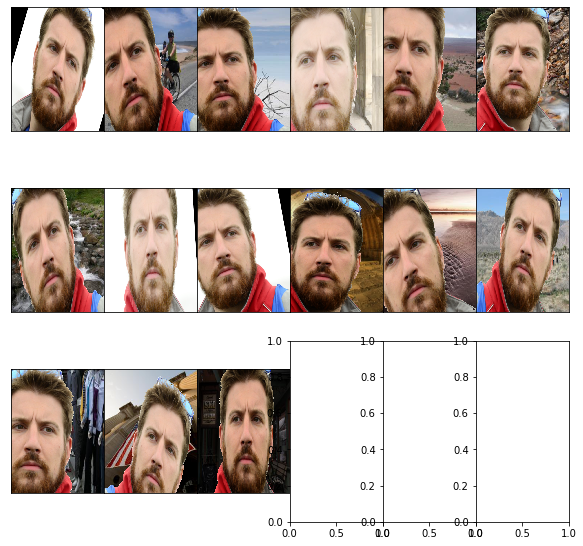

In [22]:
sampledata =[pic for pic in os.listdir(CURRENT_DIR + '/data/train/') if 'data_02544' in pic]


f, axarr = plt.subplots(3,6,figsize=(10,10))   

for i,pic in enumerate(sampledata):
    
    image = cv2.imread(CURRENT_DIR + '/data/train/' + pic)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    axarr[int(i/6),i%6].imshow(image)
    axarr[int(i/6),i%6].set_xticks([])
    axarr[int(i/6),i%6].set_yticks([])
    
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

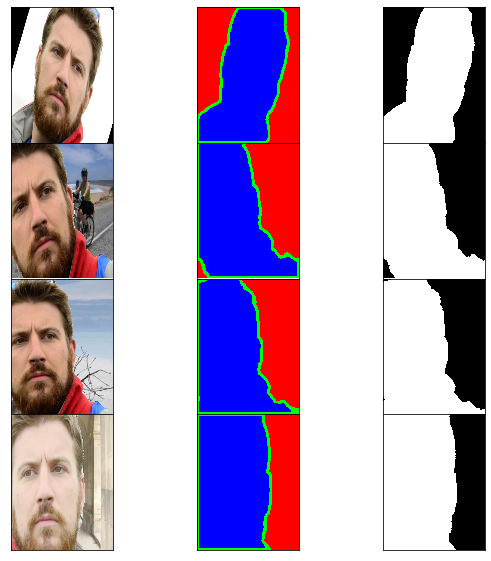

In [23]:
sampledata = [pic for pic in os.listdir(CURRENT_DIR + '/data/train/') if 'data_02544' in pic]


f, axarr = plt.subplots(4,3,figsize=(10,10),sharey=True,sharex=True)   

for i,pic in enumerate(sampledata[:4]):
    
    
    image = cv2.imread(CURRENT_DIR + '/data/train/' + pic)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    axarr[i,0].imshow(image)
    
    trimap = cv2.imread(CURRENT_DIR + '/trimap/train/' + pic.replace('data','trimap')).astype(float)
    axarr[i,1].imshow(trimap)
    
    matte = cv2.imread(CURRENT_DIR + '/matte/train/' + pic.replace('data','matte')).astype(float)
    axarr[i,2].imshow(matte,cmap='gray')


for ax in axarr:
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
    
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

This method of adding the original image to a new background highlights the flaws in the ground truth mattes.  Overall, however, they are a fairly good match to the image.  Right now, I'm not sure which is better, only using the original images or allowing this flaws to exist.  It seems to me that it will be easier for the neural network to pick up on the boundaries if there are white spaces.  It may develop a reliance on the white borders.  However, the other method will confuse the neural network as it will struggle to correctly determine the boundaries (the ground truth is not perfect).  Therefore, I will go through with this method as it allows a much broader range of acceptable backgrounds and will see how it works out.